In [1]:
import os
import gc
import zipfile
import pathlib
from pathlib import Path
import librosa
from collections import Counter
from pydub import AudioSegment
from pydub.silence import detect_silence
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from types import SimpleNamespace
import traceback
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# Globale Pfade für die Daten
ROOT_DIR = Path('../').resolve()  # Hauptverzeichnis
ZIP_DIR = ROOT_DIR / 'data'  # Ordner, der die ZIP-Dateien enthält
UNZIP_DIR = ROOT_DIR / 'Unzipped_Data_Picture'  # Zielordner für entpackte Dateien

# # Small Dataset
# TRAIN_DIR = UNZIP_DIR / 'small_train_ds'
# VAL_DIR = UNZIP_DIR / 'small_val_ds'
# TEST_DIR = UNZIP_DIR / 'small_test_ds'

# # Small 3 Labels Dataset
# TRAIN_DIR = UNZIP_DIR / '3_small_train_ds'
# VAL_DIR = UNZIP_DIR / '3_small_val_ds'
# TEST_DIR = UNZIP_DIR / '3_small_test_ds'

# # Medium Dataset
# TRAIN_DIR = UNZIP_DIR / 'medium_train_ds'
# VAL_DIR = UNZIP_DIR / 'medium_val_ds'
# TEST_DIR = UNZIP_DIR / 'medium_test_ds'

# Large Dataset
TRAIN_DIR = UNZIP_DIR / 'large_train_ds'
VAL_DIR = UNZIP_DIR / 'large_val_ds'
TEST_DIR = UNZIP_DIR / 'medium_test_ds'

# # Large 3 Labels Dataset
# TRAIN_DIR = UNZIP_DIR / '3_large_train_ds'
# VAL_DIR = UNZIP_DIR / '3_large_val_ds'
# TEST_DIR = UNZIP_DIR / '3_large_test_ds'

# # No_mod Dataset
# TRAIN_DIR = UNZIP_DIR / 'no_mod_train_ds'
# VAL_DIR = UNZIP_DIR / 'no_mod_val_ds'
# TEST_DIR = UNZIP_DIR / 'no_mod_test_ds'


# extract


In [2]:
def extract_zip(zip_path, extract_to):
    zip_path_str = str(zip_path)
    
    if not zip_path_str.endswith('.zip'):
        zip_path_str += '.zip'
    
    zip_file_path = pathlib.Path(zip_path_str)
    
    folder_name = zip_file_path.stem 
    target_folder = pathlib.Path(extract_to) / folder_name
    
    if target_folder.exists():
        print(f"Das Verzeichnis {target_folder} existiert bereits. Überspringe das Extrahieren.")
    else:
        if zip_file_path.exists():
            print(f"Extrahiere die Zip-Datei {zip_file_path} nach {extract_to}.")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Zip-Datei {zip_file_path} erfolgreich extrahiert.")
        else:
            print(f"Die Zip-Datei {zip_file_path} existiert nicht.")

def rename_audio_files(root_path):
    for root, dirs, files in os.walk(root_path):
        parent_folder = os.path.basename(root)
        for file in files:
            if not file.startswith(f"{parent_folder}_"):
                if file.endswith(('.wav', '.mp3')):  
                    
                    old_file_path = os.path.join(root, file)
                    new_file_name = f"{parent_folder}_{file}"
                    new_file_path = os.path.join(root, new_file_name)
                        
                    os.rename(old_file_path, new_file_path)
        print(f"renaming of {root_path}/{parent_folder} complete")


# extract_zip(TRAIN_DIR, UNZIP_DIR)
# extract_zip(TEST_DIR, UNZIP_DIR)
# extract_zip(VAL_DIR, UNZIP_DIR)
# rename_audio_files(UNZIP_DIR)


# split

In [3]:
def generate_statistics(total_segments, retaining_segments, discarded_segments, trash_dir):
    # Create a bar chart for the statistics
    labels = [f'Total Segments: {total_segments}', f'Valid Segments: {retaining_segments}', f'Discarded Segments: {discarded_segments}']
    values = [total_segments, retaining_segments, discarded_segments]

    plt.figure(figsize=(8, 6))
    plt.bar(labels, values, color=['blue', 'green', 'red'])
    plt.title('Audio Splitting Statistics')
    plt.ylabel('Count')
    plt.savefig(trash_dir / 'splitting_statistics.png')
    plt.close()

    print(f"Statistics saved as PNG in {trash_dir}")

def contains_completely_silent_part(segment, silence_threshold=-90.0, min_silence_len=100):
    """Check if a segment contains any completely silent part."""
    silence_ranges = detect_silence(
        segment, min_silence_len=min_silence_len, silence_thresh=silence_threshold
    )
    # If any silence range exists that is equal to or exceeds min_silence_len, return True
    return any(end - start >= min_silence_len for start, end in silence_ranges)

def plot_spectrogram(wav_path, output_dir):
    """Plot and save the spectrogram of a wav file."""
    # Load the audio file using librosa (this also returns the sample rate)
    samples, sample_rate = librosa.load(wav_path, sr=None)
    
    # Generate the spectrogram (using a Short-Time Fourier Transform, STFT)
    plt.figure(figsize=(10, 6))
    
    # Compute the spectrogram (logarithmic scale for better visualization)
    D = librosa.amplitude_to_db(librosa.stft(samples), ref=np.max)
    
    # Display the spectrogram
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='log', cmap='viridis')
    
    # Add title and labels
    plt.title(f"Spectrogram of {Path(wav_path).name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")

    # Save the plot
    spectrogram_path = output_dir / f"{Path(wav_path).stem}_spectrogram.png"
    plt.savefig(spectrogram_path)
    plt.close()

    print(f"Spectrogram saved: {spectrogram_path}")

def split_audio_dataset(input_dir):
        segment_length_ms = 1000
        output_dir = input_dir.parent / f"{input_dir.name}_splits"
        trash_dir = input_dir.parent / f"{input_dir.name}_trash"
        
        if output_dir.exists():
            print(f"Output directory already exists: {output_dir}. Skipping splitting.")
            return output_dir
        
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(trash_dir, exist_ok=True)

        total_segments = 0
        retaining_segments = 0
        discarded_segments = 0

        # Traverse the input directory and split files
        for subdir, _, files in os.walk(input_dir):
            relative_path = Path(subdir).relative_to(input_dir)  # Maintain subdirectory structure
            target_dir = output_dir / relative_path
            os.makedirs(target_dir, exist_ok=True)

            for file in files:
                if file.endswith(".wav"):  # Adjust formats as needed
                    input_path = Path(subdir) / file
                    audio = AudioSegment.from_file(input_path)
                    duration = len(audio)  # Total length of the audio in milliseconds

                    # Split and export segments
                    for i, start_time in enumerate(range(0, duration, segment_length_ms)):
                        end_time = min(start_time + segment_length_ms, duration)
                        segment = audio[start_time:end_time]
                        total_segments +=1
                        file_path = Path(file)  # Convert file string to Path
                        # segment_filename = target_dir / f"{file_path.stem}_segment_{i}.wav"
                        if contains_completely_silent_part(segment):
                            discarded_segments += 1
                            segment_filename = trash_dir / f"{file_path.stem}_segment_{i}.wav"
                            segment.export(segment_filename, format="wav")
                            plot_spectrogram(segment_filename, trash_dir)
                        else:
                            retaining_segments += 1
                            segment_filename = target_dir / f"{file_path.stem}_segment_{i}.wav"
                            segment.export(segment_filename, format="wav")
                            
                    print(f"Processed {file} into {i+1} segments in {target_dir}")

        generate_statistics(total_segments, retaining_segments, discarded_segments, trash_dir)
        print(f"All files processed. Split dataset saved in {output_dir}")
        return output_dir


# print(f"Split Audio Data in {1000}ms")
# TRAIN_DIR=split_audio_dataset(TRAIN_DIR)
# VAL_DIR=split_audio_dataset(VAL_DIR)
# TEST_DIR=split_audio_dataset(TEST_DIR)

# Mel-Spektogram

In [4]:
def process_audio_file(audio_file, input_dir, output_dir, n_mels, fmin, fmax):
    """
    Diese Funktion verarbeitet eine einzelne Audiodatei und berechnet das Mel-Spektrogramm.
    """
    # Relativer Pfad zur Eingabedatei
    relative_path = audio_file.relative_to(input_dir)
    
    # Zielpfad basierend auf der ursprünglichen Ordnerstruktur
    target_dir = output_dir / relative_path.parent
    target_dir.mkdir(parents=True, exist_ok=True)

    # Lade die Audiodatei mit librosa
    y, sr = librosa.load(audio_file, sr=44100)

    # Berechne das Mel-Spektrogramm
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)

    # Konvertiere das Mel-Spektrogramm in dB (logarithmische Skala)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Rückgabe der Daten ohne das Plotten
    return relative_path, mel_spectrogram_db, sr, target_dir, audio_file.stem

def generate_mel_spectrograms_with_structure(input_dir, output_dir, n_mels=128, fmin=20, fmax=44100, batch_size=200):
    """
    Optimierte Funktion für die Verarbeitung von Mel-Spektrogrammen:
    1. Berechnung wird parallelisiert.
    2. Ergebnisse werden sequentiell geplottet, um Thread-Sicherheitsprobleme zu vermeiden.
    3. Batches werden verwendet, um den Speicherverbrauch zu kontrollieren.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    # Überprüfen, ob die Ordnerstruktur bereits existiert
    if output_dir.exists() and any(output_dir.rglob("*.png")):
        print(f"Überspringe Verarbeitung, da {output_dir} bereits Mel-Spektrogramme enthält.")
        return

    # Liste der .wav-Dateien im input_dir
    audio_files = list(input_dir.rglob("*.wav"))

    if not audio_files:
        print("Keine Audiodateien gefunden.")
        return

    total_files = len(audio_files)
    print(f"{total_files} Audiodateien gefunden. Verarbeitung startet.")

    # Verarbeite die Dateien in Batches
    for batch_start in range(0, total_files, batch_size):
        batch_files = audio_files[batch_start:batch_start + batch_size]
        print(f"Verarbeite Batch {batch_start // batch_size + 1} von {total_files // batch_size + 1}")

        # Parallele Berechnung der Mel-Spektrogramme
        results = []
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(process_audio_file, audio_file, input_dir, output_dir, n_mels, fmin, fmax)
                for audio_file in batch_files
            ]
            for future in concurrent.futures.as_completed(futures):
                results.append(future.result())

        # Sequentielles Plotten und Speichern
        for relative_path, mel_spectrogram_db, sr, target_dir, audio_file_stem in results:
            mel_spectrogram_path = target_dir / f"{audio_file_stem}_mel_spectrogram.png"

            # Überspringen, wenn das Spektrogramm bereits existiert
            if mel_spectrogram_path.exists():
                print(f"Spektrogramm {mel_spectrogram_path} existiert bereits. Überspringen.")
                continue

            try:
                # Erstelle das Bild des Mel-Spektrogramms
                plt.figure(figsize=(2, 2))
                librosa.display.specshow(mel_spectrogram_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
                plt.axis('off')

                # Speichern des Bildes als PNG
                plt.savefig(mel_spectrogram_path, bbox_inches='tight', pad_inches=0, dpi=300)
                plt.close()
                print(f"Mel-Spektrogramm für {audio_file_stem} gespeichert in {mel_spectrogram_path}")
            except Exception as e:
                print(f"Fehler beim Plotten von {audio_file_stem}: {e}")
            finally:
                # Speicher freigeben
                del mel_spectrogram_db
                gc.collect()

    print(f"Alle Mel-Spektrogramme gespeichert in {output_dir}")

# Beispielaufruf:
# train_mel_dir = Path(f"{TRAIN_DIR.stem}_mel_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
# generate_mel_spectrograms_with_structure_parallel(TRAIN_DIR, train_mel_dir)

# val_mel_dir = Path(f"{VAL_DIR.stem}_mel_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
# generate_mel_spectrograms_with_structure_parallel(VAL_DIR, val_mel_dir)

# test_mel_dir = Path(f"{TEST_DIR.stem}_mel_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
# generate_mel_spectrograms_with_structure_parallel(TEST_DIR, test_mel_dir)


In [5]:
def compare_segments(output_dir):
    """
    Diese Funktion vergleicht Mel-Spektrogramme aus zwei verschiedenen Label-Unterordnern, 
    indem sie die ersten fünf Dateien paarweise nach ihrem Index abgleicht und als Grafik anzeigt.

    :param output_dir: Verzeichnis, das die Label-Unterordner mit Mel-Spektrogrammen enthält
    """

    output_dir = Path(output_dir)
    label_dirs = [d for d in output_dir.iterdir() if d.is_dir()]

    if len(label_dirs) < 2:
        raise ValueError("Es müssen mindestens zwei Label-Unterordner vorhanden sein.")

    # Sortiere die Label-Unterordner alphabetisch
    label_dirs.sort()

    # Liste der Dateien in jedem Label-Unterordner
    files_per_label = [sorted(label_dir.glob("*.png")) for label_dir in label_dirs]

    # Paare von Dateien basierend auf ihrem Index erstellen (maximal 5 Paare)
    pairs = list(zip(*[files[::30] for files in files_per_label]))[:5]

    # Vergleiche und zeige die Paare als Grafik an
    for idx, (file1, file2) in enumerate(pairs):
        img1 = plt.imread(file1)
        img2 = plt.imread(file2)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(f"Label 1: {file1.stem[:80]}...", fontsize=6)  # Verkürzt und kleinere Schriftgröße
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(f"Label 2: {file2.stem[:80]}...", fontsize=6)  # Verkürzt und kleinere Schriftgröße
        plt.axis('off')

        plt.suptitle(f"Vergleich {idx + 1}")
        plt.show()

    
# compare_segments(train_mel_dir)


# Build

In [6]:
def model_train_results(session):
    import matplotlib.pyplot as plt
    import numpy as np

    # Extrahieren der Daten aus dem Session-Objekt
    history = session.history
    metrics = history.history
    
    # Zugriff auf EarlyStopping Callback und Best-Weight Epoche
    early_stopping = session.callbacks[0]  # EarlyStopping Callback
    best_epoch = early_stopping.best_epoch  # Epoche des besten Modells (mit restore_best_weights)
    
    batch_size = session.model_batch_size
    
    epochs = np.array(history.epoch)

    plt.figure(figsize=(16, 6))

    # Plot für den Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["loss"], label=f"Train Loss {session.model_values[2]:.3f}")
    plt.plot(epochs, metrics["val_loss"], label=f"Val Loss {session.model_values[0]:.3f}")

    # Vertikale Linie bei der Best-Weights Epoche
    if best_epoch is not None:
        plt.axvline(
            x=best_epoch,  # 1-basierte Epoche
            color="green", 
            linestyle="--",
            label=f"Best Weights Epoch {best_epoch}"
        )

    print(session.best_model_values)  

    # Überprüfen, ob 'session.best_model_values' nicht None ist
    if session.best_model_values is not None:
        # Initialisiere die Variablen mit 'N/A'
        dropout_value = 'N/A'
        regularization_value = 'N/A'
        activation_function = 'N/A'

        # Iteriere über das Dictionary, um den richtigen Wert für dropout und regularization zu extrahieren
        for param, value in session.best_model_values.items():
            if param.name == 'dropout':
                dropout_value = value  # Der Wert von dropout
            elif param.name == 'regularization':
                regularization_value = value  # Der Wert von regularization
            elif param.name == 'activation':
                activation_function = value
    else:
        dropout_value = 'N/A'
        regularization_value = 'N/A'
        activation_function = 'N/A'

    # Überprüfe die Ausgaben
    print(f"dropout: {dropout_value}, regularization: {regularization_value}, activation: {activation_function}")

    # Jetzt korrektes Anzeigen im Plot
    plt.subplots_adjust(bottom=0.65)
    plt.figtext(
        0.5, 0.01,
        f"Batch Size: {session.model_batch_size}\n"
        # f"Training with: {'Mel_Spectogram' if mel_spectogram else 'Spectogram'}\n"
        f"HParams: {'Default' if session.best_model_values is None else f'dropout: {dropout_value}, regularization: {regularization_value}, activation: {activation_function}'}",
        fontsize=8, ha="center", va="bottom", color="black"
    )

    plt.legend()
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel("Epoch")
    plt.ylabel("Loss [CrossEntropy]")

    # Plot für die Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, 100 * np.array(metrics["accuracy"]), label=f"Train Accuracy {session.model_values[3]:.3f}")
    plt.plot(epochs, 100 * np.array(metrics["val_accuracy"]), label=f"Val Accuracy {session.model_values[1]:.3f}")

    # Vertikale Linie bei der Best-Weights Epoche
    if best_epoch is not None:
        plt.axvline(
            x=best_epoch,  # 1-basierte Epoche
            color="green", 
            linestyle="--",
            label=f"Best Weights Epoch {best_epoch}"
        )

    plt.legend()
    plt.ylim([0, 100])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy [%]")

    plt.tight_layout()
    # plt.savefig(f"./saved/{adjust_zip_file_path(base_name='history')}.png")
    # plt.savefig(f"./saved_models/{adjust_zip_file_path(base_name='history')}.png")
    plt.show()


In [7]:
def preprocess_data(train_dir, val_dir, test_dir, img_height=128, img_width=128, batch_size=32, dropout_rate=0.5, regularization_rate=0.001, activation='relu'):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

def build_model(input_shape=(128, 128, 3), num_classes=2, dropout_rate=0.5, regularization_rate=0.001, activation='relu'):

    norm_layer = layers.Normalization()
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(128, 128),
        norm_layer,
        layers.Conv2D(16, 3, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        # layers.Dropout(dropout_rate),  # Dropout bleibt hier
        layers.Conv2D(64, 3, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Flatten(),
        # layers.Dropout(dropout_rate),
        layers.Dense(128, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(regularization_rate)),  # Kleinere Dense-Schicht
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax'),
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_and_result():
    # # Define the paths for the mel-spectrogram directories
    # train_mel_dir = Path(f"{TRAIN_DIR.stem}_mel_spectrograms")
    # val_mel_dir = Path(f"{VAL_DIR.stem}_mel_spectrograms")
    # test_mel_dir = Path(f"{TEST_DIR.stem}_mel_spectrograms")

    img_height, img_width = 128, 128
    batch_size = 512

    # Load datasets
    train_ds, val_ds, test_ds = preprocess_data(train_mel_dir, val_mel_dir, test_mel_dir, img_height, img_width, batch_size)

    # Build the model
    model = build_model(input_shape=(img_height, img_width, 3), num_classes=2)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    

    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_ds, verbose=2)
    trained_epochs = len(history.epoch)
    print(f"Das Training wurde nach {trained_epochs} Epochen gestoppt.")
    best_epoch = early_stopping.best_epoch
    print(f"Das beste Modell wurde in Epoche {best_epoch} gefunden.")
        
        
    val_loss = history.history['val_loss'][best_epoch]
    val_accuracy = history.history['val_accuracy'][best_epoch]
    train_loss = history.history['loss'][best_epoch]
    train_accuracy = history.history['accuracy'][best_epoch]

    batch_size = None
    for element in train_ds.take(1):
        batch_size = element[0].shape[0] 
        break
        
    session = SimpleNamespace(
        model=model,
        history=history,
        # epochs=EPOCHS,
        callbacks=[early_stopping],
        model_values = [val_loss, val_accuracy, train_loss, train_accuracy],
        model_batch_size = batch_size,
        best_model_values = None
    )
    model_train_results(session)
    print(f"Evaluated model with best weights: val_loss={val_loss}, val_accuracy={val_accuracy}")


# train_and_result()

Das Verzeichnis I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture\large_train_ds existiert bereits. Überspringe das Extrahieren.
Das Verzeichnis I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture\medium_test_ds existiert bereits. Überspringe das Extrahieren.
Das Verzeichnis I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture\large_val_ds existiert bereits. Überspringe das Extrahieren.
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/Unzipped_Data_Picture complete
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/large_test_ds_splits complete
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/large_test_ds_trash complete
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/large_train_ds complete
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/orig-16-44-mono complete
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/upscale-from-mp3-128 complete
renaming of I:\Uni-Git\Master\Tutorial\Unzipped_Data_Picture/large_train_ds_splits 

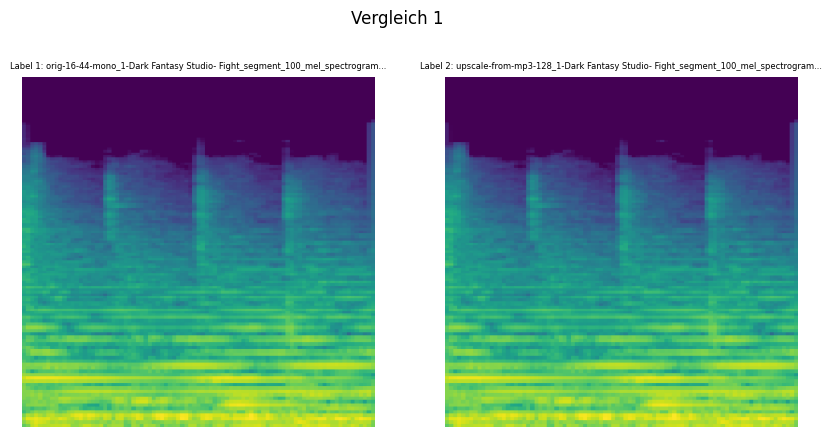

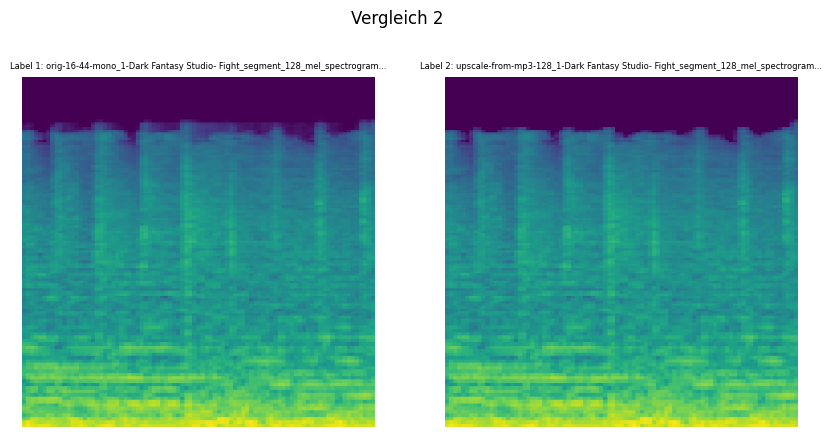

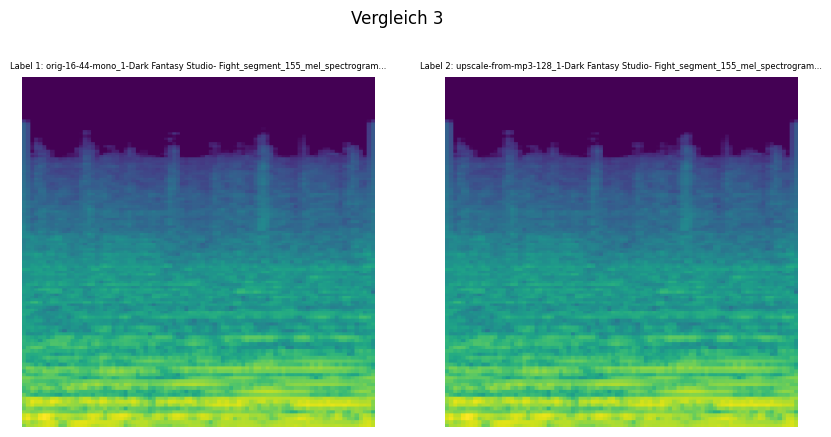

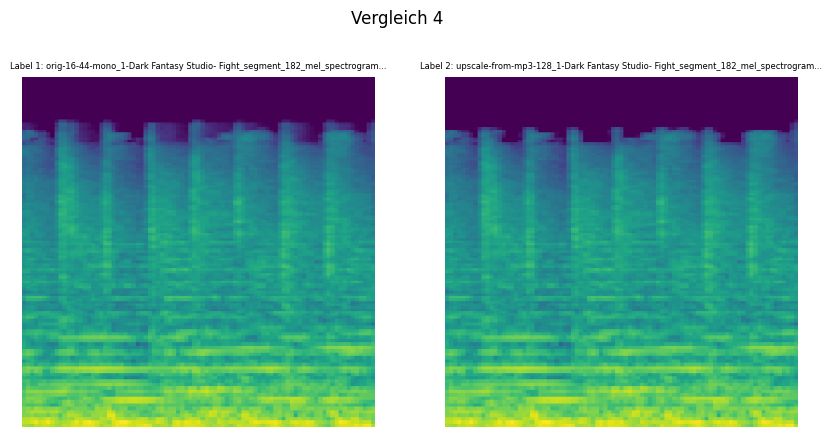

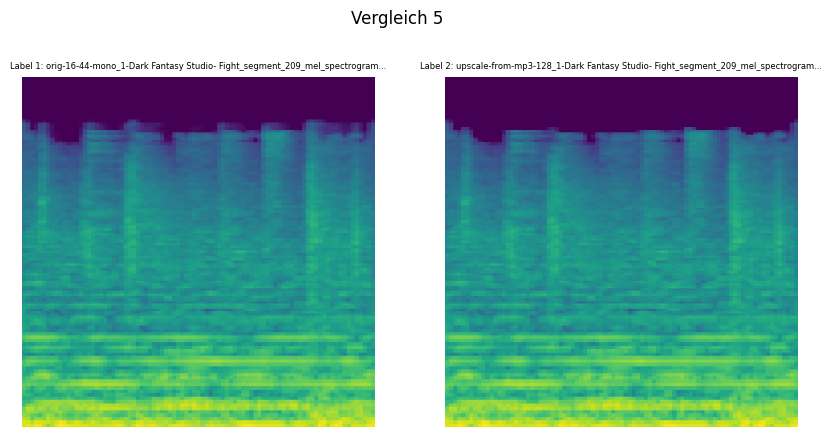

Found 105428 files belonging to 2 classes.
Found 15902 files belonging to 2 classes.
Found 246 files belonging to 2 classes.
Epoch 1/100
206/206 [==============================] - 59s 114ms/step - loss: 0.8657 - accuracy: 0.7053 - val_loss: 1.5636 - val_accuracy: 0.5074
Epoch 2/100
206/206 [==============================] - 19s 91ms/step - loss: 0.5898 - accuracy: 0.7843 - val_loss: 0.7883 - val_accuracy: 0.6088
Epoch 3/100
206/206 [==============================] - 18s 87ms/step - loss: 0.5042 - accuracy: 0.7928 - val_loss: 0.7580 - val_accuracy: 0.6099
Epoch 4/100
206/206 [==============================] - 18s 85ms/step - loss: 0.4525 - accuracy: 0.7972 - val_loss: 0.6251 - val_accuracy: 0.6487
Epoch 5/100
206/206 [==============================] - 18s 85ms/step - loss: 0.4195 - accuracy: 0.8021 - val_loss: 0.6334 - val_accuracy: 0.6340
Epoch 6/100
206/206 [==============================] - 17s 85ms/step - loss: 0.3976 - accuracy: 0.8047 - val_loss: 1.0149 - val_accuracy: 0.5587
Epoc

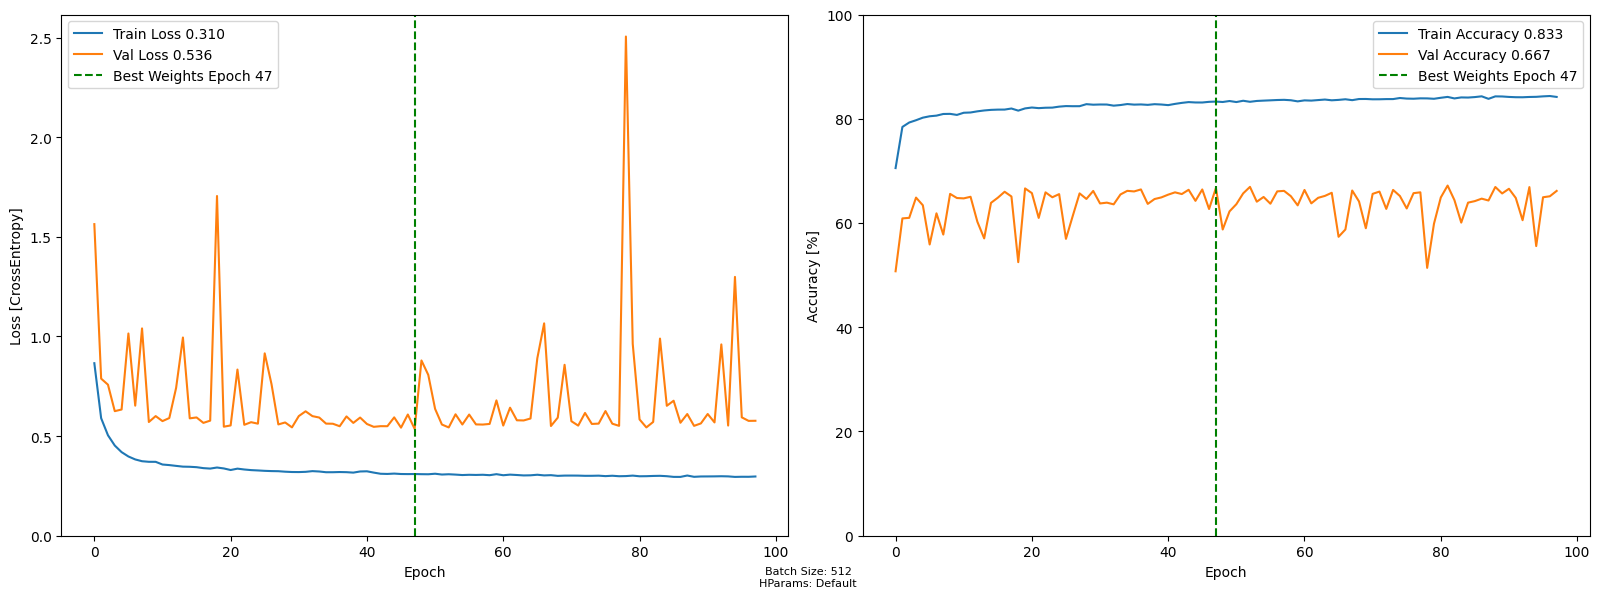

Evaluated model with best weights: val_loss=0.5361213088035583, val_accuracy=0.6670230031013489


In [8]:
if __name__ == "__main__":
    extract_zip(TRAIN_DIR, UNZIP_DIR)
    extract_zip(TEST_DIR, UNZIP_DIR)
    extract_zip(VAL_DIR, UNZIP_DIR)
    rename_audio_files(UNZIP_DIR)

    print(f"Split Audio Data in {1000}ms")
    TRAIN_DIR=split_audio_dataset(TRAIN_DIR)
    VAL_DIR=split_audio_dataset(VAL_DIR)
    TEST_DIR=split_audio_dataset(TEST_DIR)

    train_mel_dir = Path(f"{TRAIN_DIR.stem}_mel_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
    generate_mel_spectrograms_with_structure(TRAIN_DIR.resolve(), train_mel_dir)

    val_mel_dir = Path(f"{VAL_DIR.stem}_mel_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
    generate_mel_spectrograms_with_structure(VAL_DIR, val_mel_dir)

    test_mel_dir = Path(f"{TEST_DIR.stem}_mel_spectrograms")  # Der Zielordner für die Mel-Spektrogramme
    generate_mel_spectrograms_with_structure(TEST_DIR, test_mel_dir)

    compare_segments(train_mel_dir)

    train_and_result()

    